# How to Use Tutorial this repository
## Preprocess

In [1]:
import torch
torch.__version__

'1.7.0+cu101'

In [2]:
# check the GPU 
torch.cuda.get_device_name(0)  

'Tesla T4'

In [3]:
!git clone https://github.com/nakabeppu/ssd_pytorch-lightning

Cloning into 'ssd_pytorch-lightning'...
remote: Enumerating objects: 1069, done.
remote: Counting objects: 100% (1069/1069), done.
remote: Compressing objects: 100% (566/566), done.
remote: Total 1069 (delta 521), reused 1039 (delta 503), pack-reused 0
Receiving objects: 100% (1069/1069), 36.81 MiB | 48.33 MiB/s, done.
Resolving deltas: 100% (521/521), done.


In [4]:
%cd ssd_pytorch-lightning/

/content/ssd_pytorch-lightning


In [5]:
import torchvision
torchvision.__version__

'0.8.1+cu101'

In [6]:
!pip install -q pytorch_lightning==1.0.8
import pytorch_lightning as pl
pl.__version__

     |████████████████████████████████| 563kB 23.6MB/s 
     |████████████████████████████████| 829kB 61.4MB/s 
     |████████████████████████████████| 276kB 54.7MB/s 
     |████████████████████████████████| 92kB 11.9MB/s 


'1.0.8'

In [7]:
from PIL import Image
from torchvision import transforms
from xml.etree.ElementTree import parse
from glob import glob

In [8]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, root, mode='train'):
        self.root = root
        self.mode = mode
        self.aerial_maritime_labels = ['dock', 'boat', 'lift', 'jetski', 'car']
        self.transform = transforms.Compose([transforms.Resize((300, 300)), transforms.ToTensor()])
        self.data_list = sorted(glob(f'{root}/{mode}/*xml'))

    def __getitem__(self, idx):
        data = self.data_list[idx]
        parser = parse(data)

        # input
        img_path = parser.find('filename').text
        img_path = f'{self.root}/{self.mode}/{img_path}'
        img = Image.open(img_path)
        img = self.transform(img)

        # target
        size = parser.find('size')
        w = int(size.find('width').text)
        h = int(size.find('height').text)
        target = []
        for obj in parser.findall('object'):
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text) / w
            ymin = int(bbox.find('ymin').text) / h
            xmax = int(bbox.find('xmax').text) / w
            ymax = int(bbox.find('ymax').text) / h
            name = obj.find('name').text
            label = int(self.aerial_maritime_labels.index(name))
            target.append([xmin, ymin, xmax, ymax, label])
        targets = torch.tensor(target, dtype=torch.float32)

        return img, targets

    def __len__(self):
        return len(self.data_list)

In [9]:
# get the dataset
root = 'data/Aerial Maritime.v9-tiled.voc'
train = Dataset(root, mode='train')
val = Dataset(root, mode='valid')
test = Dataset(root, mode='test')

In [10]:
# fix a seed of random number
pl.seed_everything(0)

# データセットの形式を揃える
def collate_fn(batch):
    images, targets = list(zip(*batch))
    return images, targets

# batch size
batch_size = 8

# make Data Loader 
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=False, drop_last=True, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(val, batch_size, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(test, batch_size, collate_fn=collate_fn)

## Create the Model

In [11]:
from SSDNet import *

In [12]:
# 構造の確認
net = Net()
print(net)

Net(
  (vgg): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

### 重みの取得
物体検出モデルの多くは PascalVOC データセットや COCO データセットで学習済みです。そのため、学習済みの重みを初期値として学習（チューニング）させたほうが学習の収束が早くなります。  
今回も学習済みの重みを使ってチューニングを行うことにします。

In [13]:
import os
import urllib.request

weights_dir = "./weights/"
if not os.path.exists(weights_dir):
    os.mkdir(weights_dir)

# SSD parameter
url = 'https://s3.amazonaws.com/amdegroot-models/ssd300_mAP_77.43_v2.pth'
target_path = os.path.join(weights_dir, "ssd_300.pth")

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)

In [14]:
net.load_state_dict(torch.load('weights/ssd_300.pth'))

<All keys matched successfully>

## Train

In [ ]:
pl.seed_everything(0)
# tuning the Model in custom dataset
new_conf = conf(num_classes=6) # num_classes = classes + 1 (Back Ground)
net.conf = new_conf
net.num_classes=6
# train
trainer = pl.Trainer(max_epochs=50, gpus=1, deterministic=True)
trainer.fit(net, train_loader, val_loader)

In [16]:
# evaluate
results = trainer.test(test_dataloaders=test_loader)

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(4.3294, device='cuda:0'),
 'train_loss': tensor(0.4491, device='cuda:0'),
 'train_loss_epoch': tensor(0.6449, device='cuda:0'),
 'train_loss_step': tensor(0.4491, device='cuda:0'),
 'val_loss': tensor(4.9278, device='cuda:0')}
--------------------------------------------------------------------------------



In [ ]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

In [18]:
# save parameter
torch.save(net.state_dict(), 'ssd.pt')

## Test

In [19]:
net = Net(phase='test', num_classes=6).cpu().eval()
net.load_state_dict(torch.load('ssd.pt'))

<All keys matched successfully>

In [20]:
# 1 image
x, t = test[0]
y = net(x.unsqueeze(0))

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageDraw, ImageFont

In [25]:
%%capture
!if [ ! -d fonts ]; then mkdir fonts && cd fonts && wget https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKjp-hinted.zip && unzip NotoSansCJKjp-hinted.zip && cd .. ;fi

In [26]:
def visualize_results(input, outputs, threshold):

    img= input.permute(1, 2, 0).numpy()
    image = Image.fromarray((img*255).astype(np.uint8))

    aerial_maritime_labels = ['dock', 'boat', 'lift', 'jetski', 'car']

    scale = torch.Tensor(img.shape[1::-1]).repeat(2)
    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype('fonts/NotoSansCJKjp-Bold.otf', 16)

    for i in range(outputs.size(1)):
        j = 0
        while outputs[0,i,j,0] >= threshold:
            score = outputs[0,i,j,0]
            label_name = aerial_maritime_labels[i-1]
            boxes = (outputs[0,i,j,1:]*scale).cpu().numpy()
            draw.rectangle(boxes, outline='red', width=5)
            w, h = font.getsize(label_name)
            draw.rectangle([boxes[0], boxes[1], boxes[0]+w, boxes[1]+h], fill='red')
            draw.text((boxes[0], boxes[1]), label_name, font=font, fill='white')
            j+=1

    return image

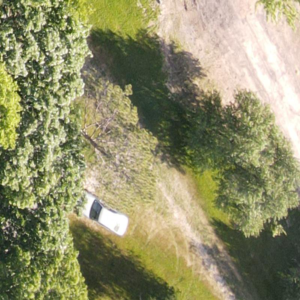

In [27]:
visualize_results(x, y, threshold=0.5)

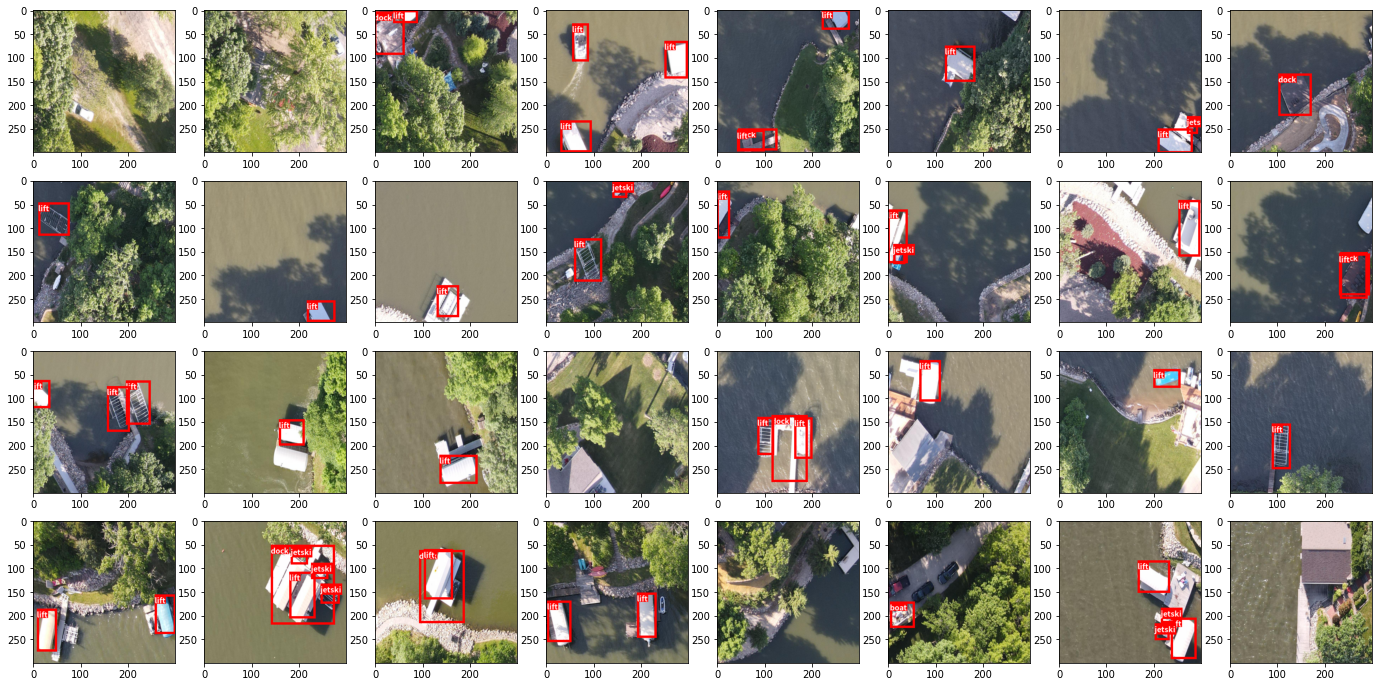

In [28]:
# all test images
plt.figure(figsize=(24, 12))
net = Net(phase='test', num_classes=6).cpu().eval()
net.load_state_dict(torch.load('ssd.pt', map_location=torch.device('cpu')))
for n in range(len(test)):
    x, t = test[n]
    y = net(x.unsqueeze(0))
    image = visualize_results(x, y, threshold=0.5)
    plt.subplot(4, 8, n+1)
    plt.imshow(image)

## mAP

In [29]:
!git clone https://github.com/Cartucho/mAP

Cloning into 'mAP'...
remote: Enumerating objects: 908, done.
remote: Total 908 (delta 0), reused 0 (delta 0), pack-reused 908
Receiving objects: 100% (908/908), 14.71 MiB | 35.61 MiB/s, done.
Resolving deltas: 100% (321/321), done.


今回のモデルの mAP の計算に必要のないものを削除しておきます。

In [30]:
import os

# delete file
dr_paths = glob('mAP/input/detection-results/*')
for path in dr_paths:
    os.remove(path)
gt_paths = glob('mAP/input/ground-truth/*')
for path in gt_paths:
    os.remove(path)

In [31]:
# ground-truth 
import xml.etree.ElementTree as ET

xml_list = glob('data/Aerial Maritime.v9-tiled.voc/test/*.xml')

for tmp_file in xml_list:
    with open(tmp_file.replace(".xml", ".txt"), "a") as new_f:
        root = ET.parse(tmp_file).getroot()
        size = root.find('size')
        w = int(size.find('width').text)
        h = int(size.find('height').text)
        for obj in root.findall('object'):
            obj_name = obj.find('name').text
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text) / w
            ymin = int(bndbox.find('ymin').text) / h
            xmax = int(bndbox.find('xmax').text) / w
            ymax = int(bndbox.find('ymax').text) / h
            new_f.write("%s %s %s %s %s\n" % (obj_name, xmin, ymin, xmax, ymax))
print("Conversion completed!")

Conversion completed!


In [32]:
import shutil
# move ground-truth 
ground_truth_paths = sorted(glob('data/Aerial Maritime.v9-tiled.voc/test/*.txt'))
for gt_file in ground_truth_paths:
    shutil.move(gt_file, 'mAP/input/ground-truth/')

In [33]:
# detection-results 
test_image_paths = sorted(glob('data/Aerial Maritime.v9-tiled.voc/test/*jpg'))

net = Net(phase='test', num_classes=6).cpu().eval()
net.load_state_dict(torch.load('ssd.pt', map_location=torch.device('cpu')))

aerial_maritime_labels = ['dock', 'boat', 'lift', 'jetski', 'car']

for test_image_path in test_image_paths:

    image = Image.open(test_image_path)
    transform = transforms.Compose([transforms.Resize((300, 300)), transforms.ToTensor()])
    img = transform(image)
    outputs = net(img.unsqueeze(0))

    with open(test_image_path.replace('.jpg', '.txt'), 'a') as new_f:
        for i in range(outputs.size(1)):
            j = 0
            while outputs[0,i,j,0] >= 0.5:
                score = outputs[0, i, j, 0].numpy()
                label_name = aerial_maritime_labels[i-1]
                boxes = (outputs[0,i,j,1:]).cpu().numpy()
                xmin, ymin, xmax, ymax = boxes
                new_f.write("%s %s %s %s %s %s\n" % (label_name, score, xmin, ymin, xmax, ymax))
                j += 1
print("Conversion completed!")

Conversion completed!


In [34]:
# move detection-result 
detection_results_paths = sorted(glob('data/Aerial Maritime.v9-tiled.voc/test/*.txt'))
for dr_file in detection_results_paths:
    shutil.move(dr_file, 'mAP/input/detection-results/')

In [35]:
%cd mAP/

/content/ssd_pytorch-lightning/mAP


In [36]:
# 算出
!python3 main.py -na

0.00% = boat AP 
0.00% = car AP 
15.97% = dock AP 
40.00% = jetski AP 
70.67% = lift AP 
mAP = 25.33%
<Figure size 640x480 with 1 Axes>


このように算出することができました。  
output に png ファイルも書き出しされています。

![mAP_results1](img/mAP_results1.png)

![mAP_results2](img/mAP_results2.png)